# CSC2541 Machine Learning For Health Assignment 1
# Pulkit Mathur
# 1005483692

# Part 1:

#### 1) Give a brief summary of the patient’s demographics (race, age, marital status, etc)?

Query -

Result - 

#### 2) What was the patient’s primary diagnosis (seq_num = 1) and the ICD-9 code?

Query -

Result - 

#### 3) How long did the patient stay in the ICU?

Query -

Result - 

#### 4) According to the discharge report, what was her condition when she was discharged?

Query -

Result - 

#### 5) What was the patient’s highest and lowest heart rates during the stay?

Query -

Result - 

In [1]:
import numpy as np
import pandas as pd
import gensim
import pickle
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,classification_report,f1_score
from sklearn import preprocessing
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Flatten
from keras.layers import LSTM
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

Using TensorFlow backend.


# Part 2a: 
#### Getting the data

In [2]:
adult_icu = pd.read_csv("/home/pulkitmathur1800/csc2548_ml4h/adult_icu")

#### Splitting the data into train and test

In [3]:
adult_icu = adult_icu.drop(['subject_id','hadm_id','icustay_id'],axis=1)
Y = adult_icu[['mort_icu','train']] 
Y_train,Y_test = Y.loc[Y['train']==1],Y.loc[Y['train']==0]

X_train,X_test = adult_icu.loc[adult_icu['train']==1],adult_icu.loc[adult_icu['train']==0]
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

#### Scaling the non-boolean columns

In [4]:
drop_columns = ['train','mort_icu']
bool_cols = [col for col in adult_icu if np.isin(adult_icu[col].dropna().unique(),[0, 1]).all()]
non_bool_cols = [item for item in adult_icu.columns if item not in bool_cols]

#Scaling the data
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X_train_scaled,X_test_scaled = scaler.fit_transform(X_train[non_bool_cols]),scaler.fit_transform(X_test[non_bool_cols])
X_train_scaled,X_test_scaled = pd.DataFrame(X_train_scaled, columns=non_bool_cols),pd.DataFrame(X_test_scaled, columns=non_bool_cols)
X_train_scaled,X_test_scaled = X_train_scaled.join(X_train[bool_cols]),X_test_scaled.join(X_test[bool_cols])
X_train_scaled,X_test_scaled = X_train_scaled.drop(drop_columns,axis=1),X_test_scaled.drop(drop_columns,axis=1)

#saving test data for use in part 2(c)
X_test_scaled.to_pickle('X_test_scaled')
Y_test.to_pickle('Y_test_notes')

##### Skewness in Testing data (this will help in evaluating classifier)

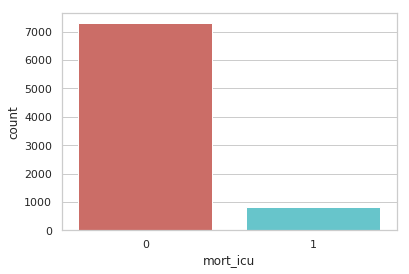

In [5]:
sns.countplot(x='mort_icu',data=Y_test, palette='hls')
plt.show()

## Training a Logistic regression with l2 regularizer

Confusion Matrix :
 [[7153  147]
 [ 682  126]]

 Classification Report
              precision    recall  f1-score   support

          0       0.91      0.98      0.95      7300
          1       0.46      0.16      0.23       808

avg / total       0.87      0.90      0.87      8108


Accuracy:  0.907068607068607

AUC:  0.7775040689000406


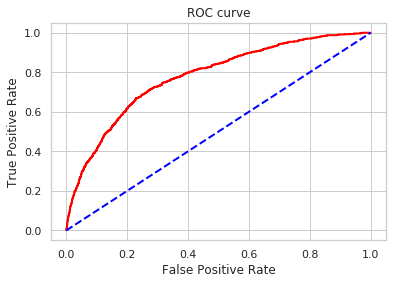

In [6]:
Y_train,Y_test = Y_train.drop(['train'],axis=1).values.squeeze(),Y_test.drop(['train'],axis=1).values.squeeze()
classifier = LogisticRegression(random_state=0,penalty="l2", C=3)
classifier.fit(X_train_scaled, Y_train)
Y_pred = classifier.predict(X_test_scaled)
Y_test_prob = classifier.predict_proba(X_test_scaled)
auc_model1 = roc_auc_score(Y_test,Y_test_prob[:,1])
matrix = confusion_matrix(Y_test, Y_pred)

print("Confusion Matrix :\n", matrix)
print("\n Classification Report\n",classification_report(Y_test, Y_pred))
print("\nAccuracy: ",classifier.score(X_train_scaled, Y_train))
print("\nAUC: ",roc_auc_score(Y_test,Y_test_prob[:,1]))

fpr, tpr,_=roc_curve(Y_test,Y_test_prob[:,1],pos_label=1)
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

#### Comment on performance-

Assumming: The objective of classifier is to predict the mortality of a patient currently admitted in ICU so that extra care can be provided to save him/her if possible.

Comments-
1. AUC > 0.5 Hence, classifier is better than random classifier.
2. Looking at the accuracy (~0.91) the classifier seems to perform good. But the dataset is skewed (very less number of rows of True lable vs False). Hence, accuracy is not a good measure to look upon.
3. Moreover, looking at confusion matrix there are 682 False Negative, that means this classifier wrongly classify 682 patients as safe which is not acceptable as these patients will not receive extra care which they might have got if the classifier would have classified them correctly.Hence, we need to look at Recall metic which is quite low (0.16)
 

### Top 5 risk factors

In [7]:
Coef_table=pd.DataFrame()
Coef_table['Risk factors'] = X_train_scaled.columns[:]
Coef_table['coef'] = classifier.coef_[0]
Coef_table = Coef_table.sort_values('coef')
Coef_table.iloc[-5:]

,Risk factors,coef
25,aniongap,2.561182
12,meanbp_mean,2.720868
17,tempc_max,3.057894
44,wbc,3.358019
28,bilirubin,3.944302


###### Explanation:
Bilirubin - Bilirubin is a yellowish substance in the blood. It forms after red blood cells break down, and it travels through the liver, gallbladder, and digestive tract before being excreted. High Bilirubin usually results when liver is not functioning.

meanbp_mean - Blood pressure outside the normal range can be harmful. High blood pressure can results in damamge to artries , brain, heart, kidneys , eyes etc.

tempc_max- Higher body temprature can 

wbc- White blooad cell plays a significant role in our body. If the count of WBC changes from normal then it can be harmful for the body.If wbc are present in higher amount than normal then these can stuck in the artries and harden, which can cause plaque to build up and can lead to heart attacks.Besides the hardening of the arteries, a higher number of white blood cells cause problems with circulation, thicker blood, and the increase of proinflammatory cytokines.

Anion Gap = Na+ – (Cl- + HCO3-) is used for the evaluation of metabolic acidosis to determine the presence of unmeasured anions.
High value of Anion gap can be harmful as explained-

High Anion gap occurs when our body starts producing acid(ketoacid) in larger amount than usual this results into condition known as acidosis which can have following harmful effects- shortness of breath, increased heart rate, jaundice, fatigue or drowsiness etc.

High values of above factors indicates that something is wrong with the bosy and if not taken care it can be life threatning . Hence, it seems justified that they have a strong positive corelation with mortality rate.

### Lowest 5 risk factor

In [52]:
Coef_table.iloc[:5]

,Risk factors,coef
16,tempc_min,-2.932108
37,platelet,-2.762496
18,tempc_mean,-2.654793
33,hemoglobin,-2.420074
4,sysbp_min,-2.233325


###### Explanation:


# -----------------------------------------------------------------------------------------------
# Part 2(b):
#### Getting the Data

In [10]:
adult_notes_raw = pd.read_csv("/home/pulkitmathur1800/csc2548_ml4h/adult_notes")
adult_notes_raw = adult_notes_raw.drop(['subject_id','hadm_id','icustay_id'],axis=1)

#### Deleting punctuation

In [11]:
def delete_punctuation(data):
    from nltk.tokenize import RegexpTokenizer
    tokenizer = RegexpTokenizer(r'[^_\W]+')
    data['chartext'].dropna(inplace=True)
    data.chartext = data.chartext.apply(lambda x: tokenizer.tokenize(x))
    return data
adult_notes_raw = delete_punctuation(adult_notes_raw)

#### Deleting stopwords

In [12]:
def delete_stopwords(data):
    stop_words = set(stopwords.words('english'))
    data['chartext'].dropna(inplace=True)
    data.chartext = data.chartext.apply(lambda x: [item for item in x if item not in stop_words])
    data['chartext'].fillna("empty", inplace=True)
    data.chartext = data.chartext.apply(lambda x: ' '.join(map(str, x)))
    return data
adult_notes_raw = delete_stopwords(adult_notes_raw)

#saving processed data which we will use in part 4(a)
adult_notes_raw.to_pickle('adult_notes_raw')

#### Splitting the data into train and test

In [68]:
#train-test-split
drop_columns = ['train','mort_icu']
X_train_notes,X_test_notes = adult_notes_raw.loc[adult_notes_raw['train']==1],adult_notes_raw.loc[adult_notes_raw['train']==0]
X_train_notes,X_test_notes = X_train_notes.drop(drop_columns,axis=1),X_test_notes.drop(drop_columns,axis=1)
Y2 = adult_notes_raw[['mort_icu','train']] 
Y_train_notes,Y_test_notes = Y2.loc[Y2['train']==1],Y2.loc[Y2['train']==0]

#saving test data for use in part 2(c)
X_test_notes.to_pickle('X_test_notes')
Y_test_notes.to_pickle('Y_test_notes')

## Tf-idf Tokenizer

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
X_train_notes = v.fit_transform(np.array(X_train_notes['chartext']))
X_test_notes = v.transform(np.array(X_test_notes['chartext']))

## Training a Logistic regression with l1 regularizer

AUC:  83.9824613454


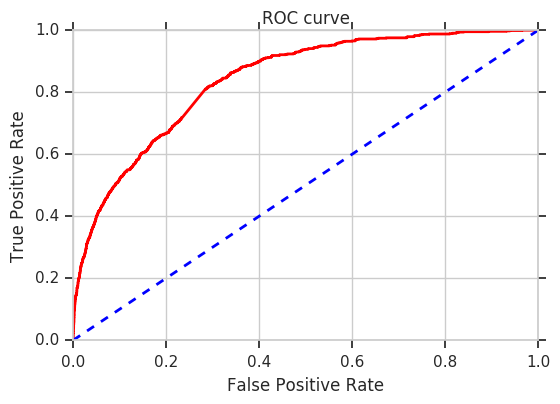

In [41]:
Y_train_notes,Y_test_notes = Y_train_notes.drop(['train'],axis=1).values.squeeze(),Y_test_notes.drop(['train'],axis=1).values.squeeze()
notes_classifier = LogisticRegression(random_state=0,penalty="l1", C=2)
notes_classifier.fit(X_train_notes, Y_train_notes)
Y_pred_notes = notes_classifier.predict(X_test_notes)
Y_test_notes_prob = notes_classifier.predict_proba(X_test_notes)
auc_model2 = roc_auc_score(Y_test_notes,Y_test_notes_prob[:,1])
print("AUC: ",roc_auc_score(Y_test_notes,Y_test_notes_prob[:,1])*100)
fpr, tpr,_=roc_curve(Y_test_notes,Y_test_notes_prob[:,1])
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

### Top 5 words associated with high mortality

In [27]:
Coef_table=pd.DataFrame()
Coef_table['Words'] = v.get_feature_names()
Coef_table['coef'] = notes_classifier.coef_[0]
Coef_table = Coef_table.sort_values('coef')
Coef_table.iloc[-5:]

,Words,coef
87458,death,7.588705
133709,paucity,8.082491
91748,dnr,8.449714
84892,corneal,12.954238
139770,prognosis,13.598452


### Lowest 5 words associated with high mortality

In [28]:
Coef_table.iloc[:5]

,Words,coef
89833,diet,-20.365169
98734,extubation,-11.216762
81198,clear,-9.350858
98717,extubated,-9.062516
169929,weaned,-8.396376


# ------------------------------------------------------------------------------------------------
# Part 2(c):

#### Getting the data

In [69]:
X_test_notes = pd.read_pickle('X_test_notes')
Y_test_notes = pd.read_pickle('Y_test_notes')
X_test_scaled = pd.read_pickle('X_test_scaled')
Y_test = pd.read_pickle('Y_test_notes')

In [59]:
Y_merged_prob = (Y_test_prob+Y_test_notes_prob)/2

AUC:  85.1181845924


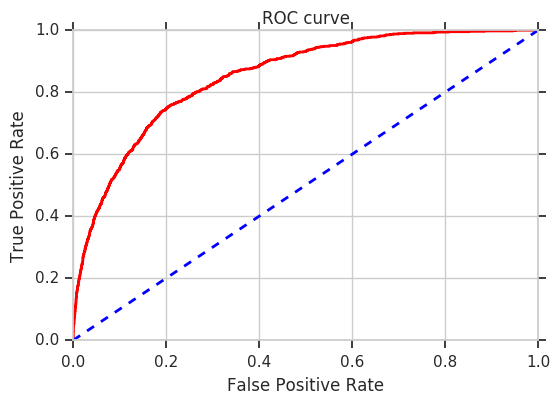

In [63]:
auc_model3 = roc_auc_score(Y_test_notes,Y_merged_prob[:,1])
print("AUC: ",roc_auc_score(Y_test_notes,Y_merged_prob[:,1])*100)
fpr, tpr,_=roc_curve(Y_test_notes,Y_merged_prob[:,1])
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

###### Explanation:

In this step we are making an Ensemble of classifier. This is known as Bagging, where we use train classifier indepedently on random subsets of data. It reduces the Variance of the model by averaging the prediction of each classifier. This helps in reducing overfitting. Hence, we saw an increase in AUC score

# --------------------------------------------------------------------------------------------------------------- Part 3(a)


#### Getting the data

In [2]:
hypertension_patients = pd.read_csv("/home/pulkitmathur1800/csc2548_ml4h/hypertension_patients")
hypertension_charts = pd.read_csv("/home/pulkitmathur1800/csc2548_ml4h/hypertension_charts")

#### Preprocessing the data

In [3]:
def filter(itemid):
    filtered_data = hypertension_charts.loc[hypertension_charts['itemid'] == itemid]
    #removing patients with fewer than 2 measurements
    temp = pd.core.frame.DataFrame(filtered_data.groupby(['subject_id','hadm_id'],as_index = False).valuenum.agg(['count'])).reset_index() 
    temp = temp.loc[temp['count']<2]
    filtered_data = filtered_data.loc[~(filtered_data['subject_id'].isin(temp['subject_id']) & filtered_data['hadm_id'].isin(temp['hadm_id']))]
    
    #preparing the data for LSTM
    filtered_data_lstm = filtered_data
    filtered_data_lstm = filtered_data_lstm.sort_values(['charttime'])
    filtered_data_lstm = pd.core.frame.DataFrame(filtered_data_lstm.groupby(['subject_id','hadm_id']).valuenum.apply(list)).reset_index()
    filtered_data_lstm = pd.merge(hypertension_patients, filtered_data_lstm, on=['subject_id','hadm_id'], how='inner')
    filtered_data_lstm = filtered_data_lstm.drop(['subject_id','hadm_id'],axis=1)

    #finding mean,max and min
    filtered_data = pd.core.frame.DataFrame(filtered_data.groupby(['subject_id','hadm_id']).valuenum.agg(['mean','max','min'])).reset_index()
    filtered_data = pd.merge(hypertension_patients, filtered_data, on=['subject_id','hadm_id'], how='inner')
    filtered_data = filtered_data.drop(['subject_id','hadm_id'],axis=1)
    filtered_data_lr = filtered_data
    return filtered_data_lr,filtered_data_lstm

heart_rate_data_lr, heart_rate_data_lstm= filter(220045)
respiratory_rate_data_lr, respiratory_rate_data_lstm= filter(220210)
o2_saturation_data_lr,o2_saturation_data_lstm = filter(220277)
blood_pressure_data_lr, blood_pressure_data_lstm = filter(220181)

##### Logistic Regression module for this part

In [4]:
def logistic_regression(data):
    #spliting the training and testing data
    X = data.drop(['hypertension'],axis=1)
    X_train,X_test = X.loc[X['train']==1],X.loc[X['train']==0]
    X_train,X_test = X_train.drop(['train'],axis=1),X_test.drop(['train'],axis=1)
    Y = data[['hypertension','train']] 
    Y_train,Y_test = Y.loc[Y['train']==1],Y.loc[Y['train']==0]
    Y_train,Y_test = Y_train.drop(['train'],axis=1).values.squeeze(),Y_test.drop(['train'],axis=1).values.squeeze()
    
    #training the model
    classifier = LogisticRegression(random_state=0,penalty="l2", C=1)
    classifier.fit(X_train, Y_train)
    Y_pred = classifier.predict(X_test)
    Y_test_prob = classifier.predict_proba(X_test)
    print("AUC: ",roc_auc_score(Y_test,Y_test_prob[:,1]))
    print("F1 Score",f1_score(Y_test,Y_pred))

#### Baseline for Heart rate

In [6]:
logistic_regression(heart_rate_data_lr)

AUC:  0.512145890711721
F1 Score 0.0014084507042253522


#### Baseline for Respiratory rate

In [8]:
logistic_regression(respiratory_rate_data_lr)

AUC:  0.5310441905864991
F1 Score 0.0014089468122578373


#### Baseline for O2 saturation

In [9]:
logistic_regression(o2_saturation_data_lr)

AUC:  0.5087042872546437
F1 Score 0.0


/home/pulkitmathur1800/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Baseline for Blood_pressure

In [10]:
logistic_regression(blood_pressure_data_lr)

AUC:  0.5283805776038468
F1 Score 0.054692775151924375


# Part 3(b):

In [83]:
def train_test_split(data):
    #X = data.drop(['hypertension'],axis=1)
    X = data
    X_train,X_test = X.loc[X['train']==1],X.loc[X['train']==0]
    X_train,X_test = X_train.drop(['train'],axis=1),X_test.drop(['train'],axis=1)
    Y = data[['hypertension','train']] 
    Y_train,Y_test = Y.loc[Y['train']==1],Y.loc[Y['train']==0]
    Y_train,Y_test = Y_train.drop(['train'],axis=1).values.squeeze(),Y_test.drop(['train'],axis=1).values.squeeze()
    X_train = X_train['valuenum'].apply(lambda x: [[i] for i in x])
    X_test = X_test.valuenum.apply(lambda x: [[i] for i in x])
    Y_train = np.array(Y_train)
    X_train = np.array(X_train)
    Y_test = np.array(Y_test)
    X_test = np.array(X_test)
    return X_train,Y_train,X_test,Y_test

In [24]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(None, 1)))
model.add(Dropout(0.2))
model.add(Dense(1,init='normal', activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

def train_generator(X_train,Y_train):
    w=0
    while True:
        x_train = np.array([X_train[w]])
        y_train = np.array([Y_train[w]])
        w+=1
        if w==X_train.shape[0]:
            w=0
        yield x_train, y_train

def input_generator(X_test):
    w=0
    while True:
        x_test = np.array([X_test[w]])
        w+=1
        yield x_test
        
def visualize_data(history):
    ## visualise training history
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

/home/pulkitmathur1800/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="normal")`


In [34]:
X_train,Y_train,X_test,Y_test = train_test_split(heart_rate_data_lstm)
#X_train['len'] = X_train.valuenum.apply(lambda x: len(x))
#min(X_train['len'])

#### Heart Rate

In [7]:
X_train,Y_train,X_test,Y_test = train_test_split(heart_rate_data_lstm)
history = model.fit_generator(train_generator(X_train,Y_train), steps_per_epoch=X_train.shape[0], epochs=3, verbose=1)

Epoch 1/3
15298/15298 [==============================] - 1000s 65ms/step - loss: 0.6892 - acc: 0.5534
Epoch 2/3
15298/15298 [==============================] - 1001s 65ms/step - loss: 0.6891 - acc: 0.5545
Epoch 3/3
15298/15298 [==============================] - 1007s 66ms/step - loss: 0.6888 - acc: 0.5550


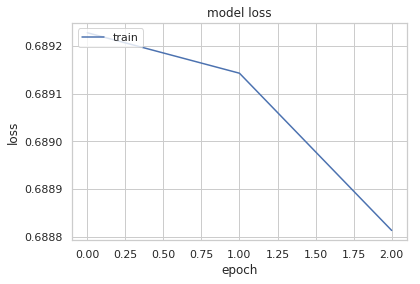

AUC:  0.529375764765223
F1 Score 0.6005293806246691


In [19]:
visualize_data(history)
Y_prob = model.predict_generator(input_generator(X_test),steps = X_test.shape[0])
Y_pred = np.array(pd.DataFrame(Y_prob)[0].apply(lambda x: 1 if x>0.5 else 0))
print("AUC: ",roc_auc_score(Y_test,Y_prob))
print("F1 Score",f1_score(Y_test,Y_pred))

#### Respiratory Rate

In [84]:
X_train,Y_train,X_test,Y_test = train_test_split(respiratory_rate_data_lstm)
model.fit_generator(train_generator(X_train,Y_train), steps_per_epoch=X_train.shape[0], epochs=3, verbose=1)

Epoch 1/3
15286/15286 [==============================] - 971s 64ms/step - loss: 0.6889 - acc: 0.5550
Epoch 2/3
15286/15286 [==============================] - 980s 64ms/step - loss: 0.6872 - acc: 0.5557
Epoch 3/3
15286/15286 [==============================] - 991s 65ms/step - loss: 0.6875 - acc: 0.5557


In [85]:
Y_prob = model.predict_generator(input_generator(X_test),steps = X_test.shape[0])
Y_pred = np.array(pd.DataFrame(Y_prob)[0].apply(lambda x: 1 if x>0.5 else 0))
print("AUC: ",roc_auc_score(Y_test,Y_prob))
print("F1 Score",f1_score(Y_test,Y_pred))

AUC:  0.5483304065982308
F1 Score 0.0


/home/pulkitmathur1800/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### O2 saturation

In [86]:
X_train,Y_train,X_test,Y_test = train_test_split(o2_saturation_data_lstm)
model.fit_generator(train_generator(X_train,Y_train), steps_per_epoch=X_train.shape[0], epochs=3, verbose=1)


Epoch 1/3
15283/15283 [==============================] - 1009s 66ms/step - loss: 0.6877 - acc: 0.5599
Epoch 2/3
15283/15283 [==============================] - 1017s 67ms/step - loss: 0.6879 - acc: 0.5581
Epoch 3/3
15283/15283 [==============================] - 1000s 65ms/step - loss: 0.6896 - acc: 0.5486


In [87]:
Y_prob = model.predict_generator(input_generator(X_test),steps = X_test.shape[0])
Y_pred = np.array(pd.DataFrame(Y_prob)[0].apply(lambda x: 1 if x>0.5 else 0))
print("AUC: ",roc_auc_score(Y_test,Y_prob))
print("F1 Score",f1_score(Y_test,Y_pred))

AUC:  0.5212313606382704
F1 Score 0.0


#### Blood_pressure

In [76]:
X_train[X_train['hypertension']==1].head(10)

,hypertension,valuenum
0,1,"[108.0, 77.0, 72.0, 78.0, 76.0, 81.0, 65.0, 75..."
2,1,"[60.0, 59.0, 66.0, 71.0, 62.0, 70.0]"
7,1,"[86.0, 99.0, 73.0, 65.0, 70.0, 72.0, 68.0, 75...."
12,1,"[92.0, 88.0, 78.0, 82.0, 89.0, 82.0, 77.0, 96...."
21,1,"[75.0, 69.0, 77.0, 68.0, 68.0, 84.0, 64.0, 72...."
23,1,"[89.0, 84.0, 73.0, 75.0, 79.0, 70.0, 70.0, 67...."
28,1,"[74.0, 76.0, 75.0, 75.0, 93.0, 74.0, 96.0, 96...."
29,1,"[106.0, 101.0, 84.0, 86.0, 91.0, 82.0, 89.0, 8..."
30,1,"[62.0, 64.0, 69.0, 63.0, 65.0, 72.0, 67.0, 88...."
34,1,"[74.0, 86.0, 63.0, 86.0, 76.0, 63.0, 65.0, 75...."


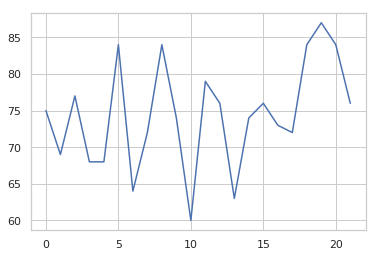

In [82]:
#X_train,Y_train,X_test,Y_test = train_test_split(blood_pressure_data_lstm)
plt.plot(X_train['valuenum'][21])

In [ ]:
def filter(itemid):
    filtered_data = hypertension_charts.loc[hypertension_charts['itemid'] == itemid]
    #removing patients with fewer than 2 measurements
    temp = pd.core.frame.DataFrame(filtered_data.groupby(['subject_id','hadm_id'],as_index = False).valuenum.agg(['count'])).reset_index() 
    temp = temp.loc[temp['count']<2]
    filtered_data = filtered_data.loc[~(filtered_data['subject_id'].isin(temp['subject_id']) & filtered_data['hadm_id'].isin(temp['hadm_id']))]


In [88]:
X_train,Y_train,X_test,Y_test = train_test_split(blood_pressure_data_lstm)
model.fit_generator(train_generator(X_train,Y_train), steps_per_epoch=X_train.shape[0], epochs=3, verbose=1)

Epoch 1/3
15013/15013 [==============================] - 501s 33ms/step - loss: 0.6889 - acc: 0.5540
Epoch 2/3
15013/15013 [==============================] - 498s 33ms/step - loss: 0.6885 - acc: 0.5547
Epoch 3/3
15013/15013 [==============================] - 500s 33ms/step - loss: 0.6891 - acc: 0.5531


In [89]:
Y_prob = model.predict_generator(input_generator(X_test),steps = X_test.shape[0])
Y_pred = np.array(pd.DataFrame(Y_prob)[0].apply(lambda x: 1 if x>0.5 else 0))
print("AUC: ",roc_auc_score(Y_test,Y_prob))
print("F1 Score",f1_score(Y_test,Y_pred))

AUC:  0.4909549227370299
F1 Score 0.0007171029042667623


# ----------------------------------------------------------------------------------------------------
# Part 3(c):

LSTM Performance was nearly the same as that of baseline (logistic regression) and it did not improve even with different number of hidden layers, different number of neurons, number of epochs and even after using regularizer (dropout). 

Hypertension anxiety, tension, smocking, obesity 

# --------------------------------------------------------------------------------------------------------------
# Part 4(a):

In [ ]:
adult_notes_raw = pd.read_csv("/home/pulkitmathur1800/csc2548_ml4h/adult_notes")
adult_notes_raw = adult_notes_raw.drop(['subject_id','hadm_id','icustay_id'],axis=1)
adult_notes_raw = delete_punctuation(adult_notes_raw)
adult_notes_raw = delete_stopwords(adult_notes_raw)

In [81]:
#remove
adult_notes_raw = pd.read_pickle('adult_notes_raw')

In [82]:
adult_notes_lda = adult_notes_raw.drop(["train","mort_icu"],axis=1)
text_data=[]
for i in range(adult_notes_lda.shape[0]):
    text_data.append(adult_notes_lda['chartext'][i].split())

In [11]:
#create dictionary
dictionary = corpora.Dictionary(text_data)
#Term document frequency
corpus = [dictionary.doc2bow(text) for text in text_data]
dictionary.save('dictionary.gensim')

In [196]:
#remove
dictionary = corpora.Dictionary.load('dictionary.gensim') 
corpus = [dictionary.doc2bow(text) for text in text_data]

In [18]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 20, id2word=dictionary)
ldamodel.save('model20.gensim')

In [48]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 50, id2word=dictionary)
ldamodel.save('model50.gensim')

In [49]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 100, id2word=dictionary)
ldamodel.save('model100.gensim')

In [84]:
#remove
ldamodel20 = gensim.models.ldamodel.LdaModel.load('model20.gensim')
ldamodel50 = gensim.models.ldamodel.LdaModel.load('model50.gensim')
ldamodel100 = gensim.models.ldamodel.LdaModel.load('model100.gensim')

In [52]:
# Compute Coherence Score using UMass
def print_coherence(ldamodel):
    coherence_model_lda = CoherenceModel(model=ldamodel, corpus=corpus ,dictionary=dictionary, coherence="u_mass")
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)
print("LDA model for topics = 20\n")
print_coherence(ldamodel20)
print("LDA model for topics = 20\n")
print_coherence(ldamodel50)
print("LDA model for topics = 20\n")
print_coherence(ldamodel100)


Coherence Score:  -0.450802145345

Coherence Score:  -0.616188765437

Coherence Score:  -0.620064586976


In [201]:
words = [['respiratory'],['vomiting'], ['urine'], ['pulse']]
Bow = [dictionary.doc2bow(keyword) for keyword in words] 
topics = ldamodel20.get_document_topics(Bow,per_word_topics=True)

In [223]:
for t in topics:
    wordID, topic = t[1][0]
    print('Topic',topic,' for ',dictionary[wordID])

Topic [17]  for  respiratory
Topic [8]  for  vomiting
Topic [4]  for  urine
Topic [16]  for  pulse


#### Respiratory

In [227]:
ldamodel20.print_topic(17,40)

'0.050*"trach" + 0.050*"stent" + 0.025*"bronch" + 0.025*"tracheal" + 0.020*"IP" + 0.015*"TBM" + 0.015*"Y" + 0.013*"bronchoscopy" + 0.012*"rigid" + 0.011*"tracheostomy" + 0.009*"reconstruction" + 0.009*"tracheobronchomalacia" + 0.008*"tracheomalacia" + 0.007*"secretions" + 0.007*"trachea" + 0.007*"Tracheobronchomalacia" + 0.007*"Tracheostomy" + 0.007*"placement" + 0.006*"neck" + 0.006*"Trach" + 0.006*"stenosis" + 0.005*"bronchomalacia" + 0.005*"Pt" + 0.005*"OR" + 0.005*"granulation" + 0.004*"1" + 0.004*"p" + 0.004*"epidural" + 0.004*"bronchus" + 0.004*"tissue" + 0.004*"malacia" + 0.004*"stridor" + 0.004*"tracheoplasty" + 0.004*"mainstem" + 0.004*"4" + 0.003*"Tracheal" + 0.003*"tube" + 0.003*"TSICU" + 0.003*"flex" + 0.003*"airway"'

Topic- "Management of Tracheobronchial diseases"

#### Vomiting

In [229]:
ldamodel20.print_topic(8,40)

'0.012*"2" + 0.010*"Pt" + 0.009*"1" + 0.009*"pain" + 0.008*"GI" + 0.007*"3" + 0.007*"pt" + 0.006*"bleeding" + 0.006*"Name" + 0.005*"c" + 0.005*"4" + 0.005*"bleed" + 0.005*"Hct" + 0.005*"w" + 0.004*"5" + 0.004*"6" + 0.004*"HCT" + 0.004*"given" + 0.004*"IV" + 0.004*"No" + 0.004*"stable" + 0.004*"blood" + 0.004*"7" + 0.003*"units" + 0.003*"liver" + 0.003*"hct" + 0.003*"Last" + 0.003*"8" + 0.003*"abdominal" + 0.003*"Plan" + 0.003*"stool" + 0.003*"abd" + 0.003*"EGD" + 0.003*"GIB" + 0.003*"AM" + 0.002*"renal" + 0.002*"today" + 0.002*"cirrhosis" + 0.002*"noted" + 0.002*"9"'

Topic- "Diagonosis and management of Gastro intestinal bleeding"
stool bleed 

#### Urine

In [230]:
ldamodel20.print_topic(4,40)

'0.017*"pt" + 0.016*"Pt" + 0.006*"Name" + 0.005*"hr" + 0.005*"w" + 0.005*"pain" + 0.004*"2" + 0.004*"1" + 0.004*"noted" + 0.004*"given" + 0.003*"100" + 0.003*"5" + 0.003*"clear" + 0.003*"c" + 0.003*"3" + 0.003*"Plan" + 0.003*"status" + 0.003*"IV" + 0.003*"No" + 0.003*"sats" + 0.003*"Neuro" + 0.003*"per" + 0.003*"monitor" + 0.002*"urine" + 0.002*"care" + 0.002*"4" + 0.002*"Last" + 0.002*"7" + 0.002*"today" + 0.002*"shift" + 0.002*"HR" + 0.002*"BP" + 0.002*"cough" + 0.002*"well" + 0.002*"commands" + 0.002*"A" + 0.002*"able" + 0.002*"NI" + 0.002*"placed" + 0.002*"resp"'

No sense

#### Pulse

In [231]:
ldamodel20.print_topic(16,40)

'0.016*"1" + 0.012*"mL" + 0.010*"2" + 0.009*"3" + 0.009*"No" + 0.009*"AM" + 0.008*"0" + 0.008*"dL" + 0.008*"4" + 0.007*"8" + 0.007*"mg" + 0.007*"5" + 0.006*"L" + 0.006*"9" + 0.006*"7" + 0.006*"6" + 0.005*"12" + 0.005*"PM" + 0.005*"10" + 0.004*"mEq" + 0.004*"Assessment" + 0.004*"ICU" + 0.004*"Other" + 0.004*"Not" + 0.004*"assessed" + 0.004*"24" + 0.004*"Plan" + 0.004*"11" + 0.003*"Response" + 0.003*"Action" + 0.003*"Name" + 0.003*"C" + 0.003*"20" + 0.003*"pulse" + 0.003*"history" + 0.003*"status" + 0.003*"Total" + 0.003*"Last" + 0.003*"given" + 0.003*"medications"'

Topic- "How to assist and give fluids in medication to a patient"
fluid low - bp diarreo,loose motion  -->pulkse low